In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import json
import csv
from scipy.stats import shapiro
import datetime as dt

In [147]:
import seaborn as sns
sns.set(style="ticks")
sns.set_color_codes("colorblind")
sns.set(style="darkgrid")

In [148]:
import warnings
warnings.filterwarnings('ignore')

In [149]:
color = [
'#000000',
'#000080',
'#0B0BFF',
'#98B5FF', 
'#BBC9DB',
'#797975',
'#0198E1',
'#00688B',
'#74CDDC', #nej
'#05EDFF',  
'#C9FFFF', 
'#8FBCBC',
'#457371',
'#28AE7B',
'#4DFFA5'
]

In [150]:
soubor = pd.read_csv('final.csv', encoding='utf-8', low_memory=False)

In [ ]:
soubor['TIMETABLE_ARRIVAL_TIME'] = pd.to_datetime(soubor['TIMETABLE_ARRIVAL_TIME']).dt.time

In [152]:
before_covid = soubor[soubor['DATE'] <= '2020-05-17']

In [153]:
len(before_covid['UNICORN'].unique())

249

In [154]:
after_covid = soubor[soubor['DATE'] >= '2020-05-18']

In [155]:
len(after_covid['UNICORN'].unique())

138

In [191]:
after_covid['TIMETABLE_ARRIVAL_TIME'].sp

2100    07:45:00
2101    07:47:00
2102    07:51:00
2103    07:52:00
2104    07:53:00
          ...   
5800    11:45:00
5801    11:46:00
5802    11:47:00
5803    11:49:00
5804    11:53:00
Name: TIMETABLE_ARRIVAL_TIME, Length: 2070, dtype: object

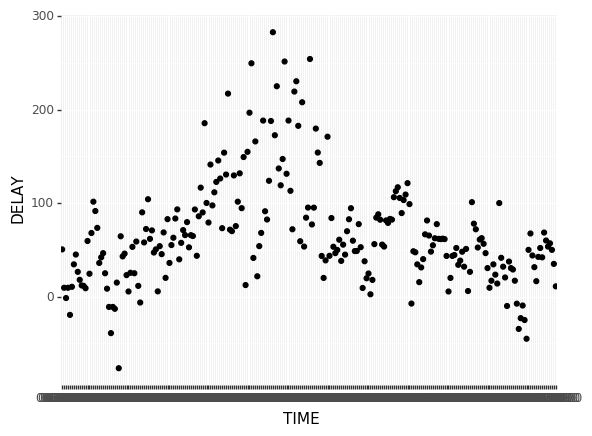

<ggplot: (-9223371892206017032)>

In [184]:
avg_delay_day = after_covid.groupby(['TIMETABLE_ARRIVAL_TIME'])[['DELAY']].mean()
avg_delay_day = avg_delay_day.reset_index()

#avg_delay_day['TIMETABLE_ARRIVAL_TIME'].min


ggplot(avg_delay_day, aes(x='TIMETABLE_ARRIVAL_TIME', y='DELAY')) + \
    geom_point() + \
    geom_line() + \
    xlab("TIME") + \
    ylab("DELAY")

In [7]:
df = data

In [8]:
#sns.pairplot(df[['DELAY','DIFF_DELAY','SEQUENCE']])

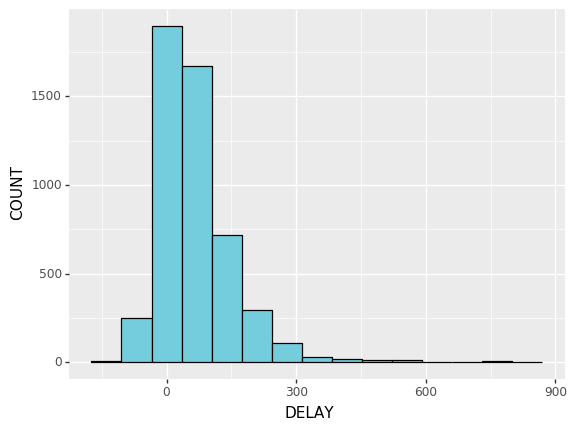

<ggplot: (-9223371883880307548)>

In [9]:
# histogram
plot_hist1 = ggplot(df, aes(x='DELAY')) + \
            geom_histogram(color='black', fill='#74CDDC', bins=15) + \
            xlab("DELAY") + \
            ylab("COUNT")

plot_hist1

In [10]:
# normality test
stat, p = shapiro(df['DELAY'])
print(f'Statistics={stat}, p={round(p,5)}')

alpha = 0.1
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.8426801562309265, p=0.0
Sample does not look Gaussian (reject H0)


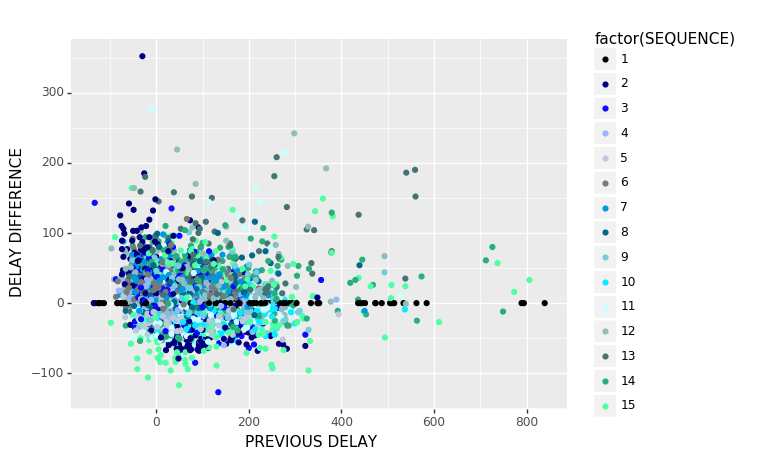

<ggplot: (-9223371883880307008)>

In [11]:
# zavislost zpozdeni z predchozi zastavky na rozdilu ve zpozdeni na urovni vsech zastavek 
plot_point1 = ggplot(df,(aes(x='PREV_DELAY', y='DIFF_DELAY',color = 'factor(SEQUENCE)'))) + \
        scale_color_manual(values=color) + \
        geom_point() + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point1

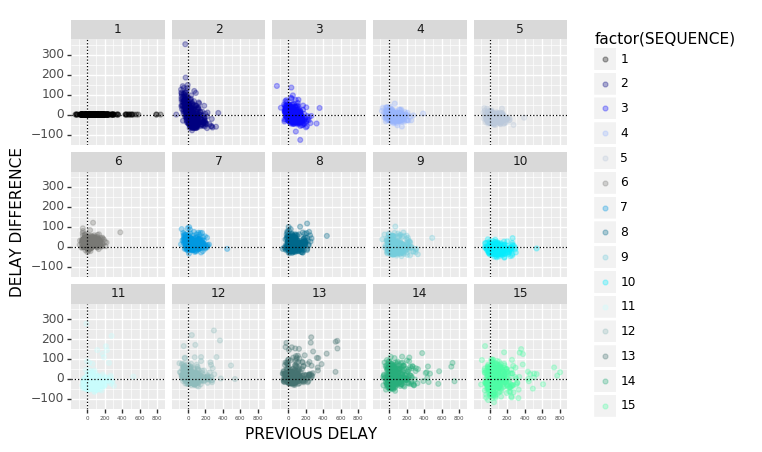

<ggplot: (-9223371883879655324)>

In [12]:
# zavislost zpozdeni z predchozi zastavky na rozdilu ve zpozdeni na urovni jednotlivych zastavek 
plot_point2 = ggplot(df, aes(x='PREV_DELAY', y='DIFF_DELAY', color = 'factor(SEQUENCE)' )) + \
        geom_point(alpha=0.3) + \
        geom_hline(yintercept=0,linetype='dotted') + \
        geom_vline(xintercept=0,linetype='dotted') + \
        theme(axis_text_x = element_text(size=4)) + \
        facet_wrap(['SEQUENCE'], nrow=3) + \
        scale_color_manual(values=color) + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point2

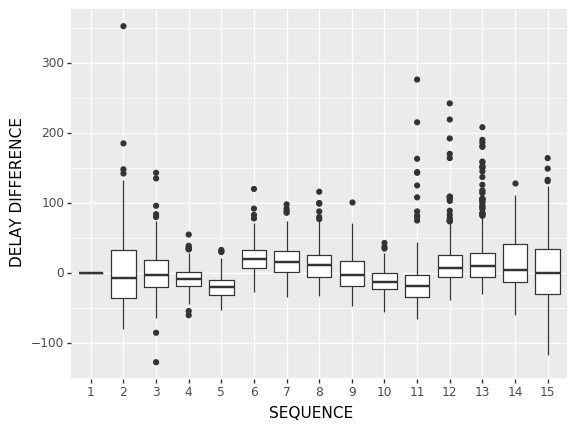

<ggplot: (-9223371883877945772)>

In [13]:
# boxplot rozdilu zpozdeni na jednotlive zastavky 
# a boxplot of the arrival difference for each bus stop, what this plot shows the spread of the delays with some outliers
df['SEQUENCE_cat'] = df['SEQUENCE'].astype('category')

plot_box1 = ggplot(df, aes(x='SEQUENCE_cat', y='DIFF_DELAY')) + \
            geom_boxplot() + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE")
plot_box1

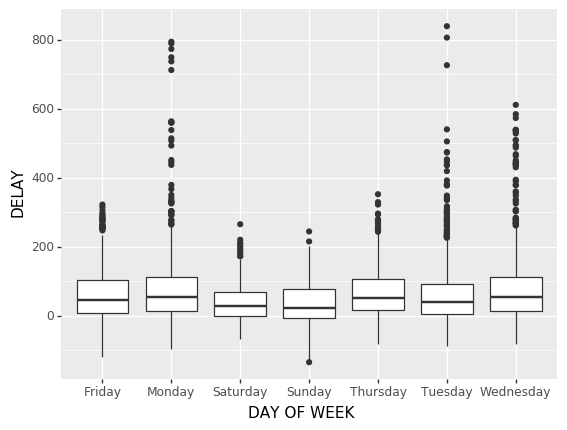

<ggplot: (-9223371883877927708)>

In [14]:
# boxplot zpozdeni v zavislosti na dni v tydnu
df['DAY_OF_WEEK_cat'] = df['DAY_OF_WEEK'].astype('category')

plot_box2 = ggplot(df, aes(x='DAY_OF_WEEK_cat', y='DELAY')) + \
            geom_boxplot() + \
            xlab("DAY OF WEEK") + \
            ylab("DELAY")
plot_box2

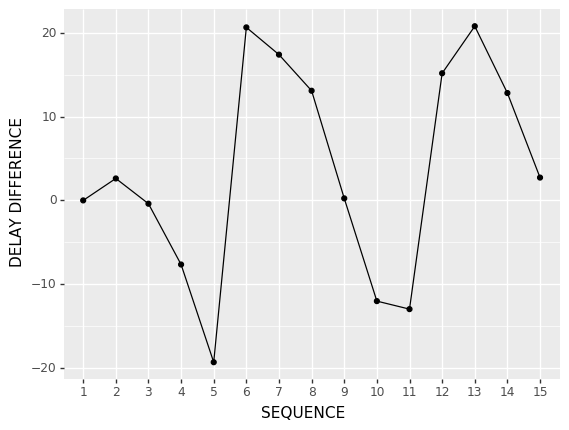

<ggplot: (-9223371883877770632)>

In [15]:
# 
avg_delay_for_stop = df.groupby(['SEQUENCE'])[['DIFF_DELAY']].mean()
avg_delay_for_stop = avg_delay_for_stop.reset_index()

ggplot(avg_delay_for_stop, aes(x='SEQUENCE', y='DIFF_DELAY')) + \
    geom_point() + \
    geom_line() + \
    scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)) + \
    xlab("SEQUENCE") + \
    ylab("DELAY DIFFERENCE")

In [16]:
# populace - vsechny hodnoty  
df['DELAY'].describe()

count    5025.000000
mean       65.437413
std        90.389346
min      -135.000000
25%         8.000000
50%        45.000000
75%       102.000000
max       839.000000
Name: DELAY, dtype: float64

In [17]:
df.groupby('SEQUENCE')['DIFF_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
SEQUENCE,,,,,,,,
1,335.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,335.0,2.614925,52.281691,-79.0,-36.0,-7.0,33.5,352.0
3,335.0,-0.394030,30.956121,-127.0,-20.0,-2.0,19.0,143.0
4,335.0,-7.641791,15.926573,-60.0,-18.0,-9.0,2.0,55.0
5,335.0,-19.289552,16.115128,-52.0,-31.5,-20.0,-10.0,33.0
6,335.0,20.623881,19.005405,-27.0,7.0,20.0,33.0,120.0
7,335.0,17.376119,21.473881,-34.0,2.0,16.0,31.0,98.0
8,335.0,13.071642,25.346833,-32.0,-6.0,11.0,26.0,116.0
9,335.0,0.241791,25.505865,-47.0,-19.0,-3.0,17.0,101.0


In [18]:
df[df['SEQUENCE']!=13]['DIFF_DELAY'].describe()

count    4690.000000
mean        2.307676
std        32.286020
min      -127.000000
25%       -17.000000
50%         0.000000
75%        18.000000
max       352.000000
Name: DIFF_DELAY, dtype: float64

In [19]:
df[df['SEQUENCE']==13]['DIFF_DELAY'].describe()

count    335.000000
mean      20.764179
std       41.479970
min      -30.000000
25%       -6.000000
50%       10.000000
75%       28.500000
max      208.000000
Name: DIFF_DELAY, dtype: float64

In [20]:
# zkouska grupovani a zprumerovani
# avg_delay = df.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DELAY']].mean().unstack()

In [21]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'], days)
df.sort_values('DAY_OF_WEEK')

,TRIP_ID,ROUTE,DAY_OF_WEEK,DATE,UNICORN,START_TIME,HEADSIGN,STOP_ID,STOP_SEQUENCE,STOP_NAME,SHAPE_DIST_TRAVELED,DELAY,ORIGIN_TIMESTAMP,DIFF_DELAY,PREV_DELAY,SEQUENCE,SEQUENCE_cat,DAY_OF_WEEK_cat
4536,331_241_200302,331,Monday,2020-05-18,331_241_200302_18_May,06:46:00,"Praha,Kačerov",U783Z2,20,U Libušské sokolovny,18.11122,-15.0,"Mon, 18 May 2020 07:24:44 Z",9.0,-24.0,7,7,Monday
957,333_1064_200302,333,Monday,2020-05-04,333_1064_200302_04_May,06:59:00,"Praha,Kačerov",U893Z4,26,Zálesí,17.03180,16.0,"Mon, 04 May 2020 07:37:12 Z",23.0,-7.0,13,13,Monday
956,333_1064_200302,333,Monday,2020-05-04,333_1064_200302_04_May,06:59:00,"Praha,Kačerov",U656Z2,25,Sídliště Krč,16.56781,-7.0,"Mon, 04 May 2020 07:35:57 Z",-17.0,10.0,12,12,Monday
955,333_1064_200302,333,Monday,2020-05-04,333_1064_200302_04_May,06:59:00,"Praha,Kačerov",U749Z2,24,Tempo,16.22898,10.0,"Mon, 04 May 2020 07:35:06 Z",8.0,2.0,11,11,Monday
954,333_1064_200302,333,Monday,2020-05-04,333_1064_200302_04_May,06:59:00,"Praha,Kačerov",U194Z2,23,Jalodvorská,15.36010,2.0,"Mon, 04 May 2020 07:33:21 Z",-34.0,36.0,10,10,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,333_1037_200307,333,Sunday,2020-05-03,333_1037_200307_03_May,10:39:00,"Praha,Kačerov",U194Z2,23,Jalodvorská,15.36010,85.0,"Sun, 03 May 2020 11:14:31 Z",-18.0,103.0,10,10,Sunday
2033,333_1037_200307,333,Sunday,2020-05-03,333_1037_200307_03_May,10:39:00,"Praha,Kačerov",U804Z2,22,U Zvoničky,15.00124,103.0,"Sun, 03 May 2020 11:13:43 Z",-24.0,127.0,9,9,Sunday
2032,333_1037_200307,333,Sunday,2020-05-03,333_1037_200307_03_May,10:39:00,"Praha,Kačerov",U335Z2,21,Libuš,14.69057,127.0,"Sun, 03 May 2020 11:13:09 Z",5.0,122.0,8,8,Sunday
1695,333_1014_200307,333,Sunday,2020-05-10,333_1014_200307_10_May,11:38:00,"Praha,Kačerov",U1502Z2,14,"Dolní Břežany,Náměstí",9.79442,13.0,"Sun, 10 May 2020 12:00:14 Z",0.0,-56.0,1,1,Sunday


In [22]:
days_col = ['#74CDDC' , '#ffffb3','#BBC9DB','#fb8072','#386cb0','#28AE7B','#4DFFA5']

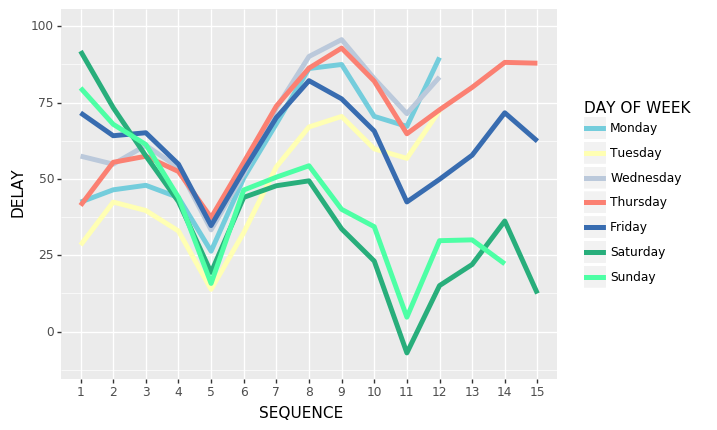

<ggplot: (-9223371883877620440)>


In [23]:
avg_delay1 = df.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DELAY']].mean()
avg_delay1 = avg_delay1.reset_index()
plot_week1 = ggplot(avg_delay1, aes(x='SEQUENCE', y='DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY") + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)) + \
            ylim(-10,100)
print(plot_week1)

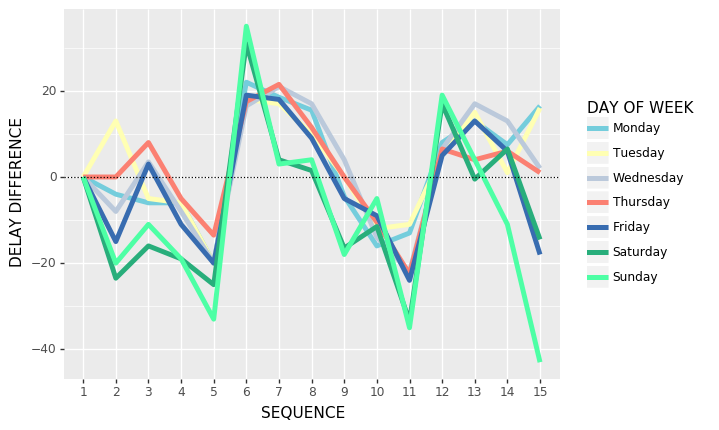

<ggplot: (-9223371883877762344)>


In [24]:
avg_diff_delay = df.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DIFF_DELAY']].median()
avg_diff_delay = avg_diff_delay.reset_index()
plot_week2 = ggplot(avg_diff_delay, aes(x='SEQUENCE', y='DIFF_DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE") + \
            geom_hline(yintercept=0,linetype='dotted') + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))    
print(plot_week2)